<a href="https://colab.research.google.com/github/ValdemarQ/B_Class/blob/master/v2_Tribe_of_AI_B_Class_Project_Plant_Pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # Planth Pathology Detection

> Identify the category of foliar diseases in apple trees [Kaggle competition URL](https://www.kaggle.com/c/plant-pathology-2020-fgvc7)

  ![Heading](https://storage.googleapis.com/kaggle-competitions/kaggle/18648/logos/header.png?t=2020-02-20-17-30-35)




1. **Import needed packages**
2. **Prepare/Showcase dataset**
  *   Load dataset
  *   EDA

3. **Fast.ai v1**
  *   Baseline model with TL
  *   With Augmentation, LR improvments
  *   Bigger model with Resnet 50



4. **Pytorch Implementation**
  * Data prep
  * Model architecture
  * Baseline model
    * Transfer learning
  * Hyperparm tuninig/transforms
    * Augmentation etc

5. **Submit to Kaggle**
  * Standings?


6. **Tensorflow Implementation**
  * Try tensorflow 

7. **FastAi v2**
 * Try v2










In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib as plt
import seaborn as sns

from fastai.vision import *

In [0]:
path = Path('/content/drive/My Drive/data/plant_pathology/')

In [137]:
path.ls()

[PosixPath('/content/drive/My Drive/data/plant_pathology/valid'),
 PosixPath('/content/drive/My Drive/data/plant_pathology/sample_submission.csv'),
 PosixPath('/content/drive/My Drive/data/plant_pathology/test.csv'),
 PosixPath('/content/drive/My Drive/data/plant_pathology/train.csv'),
 PosixPath('/content/drive/My Drive/data/plant_pathology/images'),
 PosixPath('/content/drive/My Drive/data/plant_pathology/models'),
 PosixPath('/content/drive/My Drive/data/plant_pathology/train')]

In [138]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


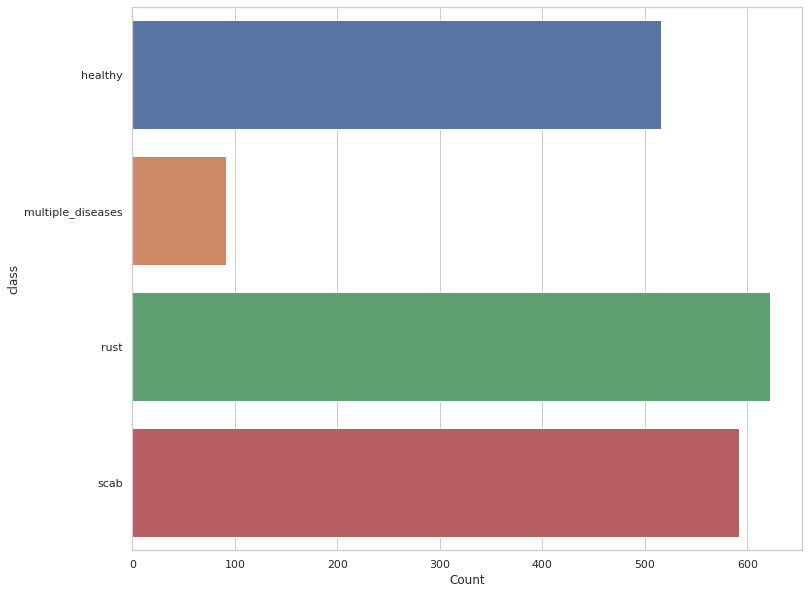

In [139]:
# Create Class count dataframe
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ['class', 'Count']
class_count.drop(class_count.index[0], inplace=True)

# Visualize class distribution as Barchartfig, 
sns.set(style="whitegrid")
plt.subplots(figsize=(12,10))
sns.barplot(y="class", x="Count",  data=class_count);

In [140]:
#Dataframe preprocessing
df = pd.read_csv(path/'train.csv')

def replace_value(row):
   for c in df.columns:
     if row[c]==1:
       return c

def add_jpg(row):
  return row['image_id']+'.jpg'


df['label'] = df.apply(replace_value, axis=1)
df = df[['image_id','label']]
df["encoded_label"] = df["label"].astype('category').cat.codes
df['image_url'] = df.apply(add_jpg, axis=1)
df.head()

,image_id,label,encoded_label,image_url
0,Train_0,scab,3,Train_0.jpg
1,Train_1,multiple_diseases,1,Train_1.jpg
2,Train_2,healthy,0,Train_2.jpg
3,Train_3,rust,2,Train_3.jpg
4,Train_4,healthy,0,Train_4.jpg


In [0]:
data = ImageDataBunch.from_df(path, df=df, folder='images', valid_pct=0.2, suffix='.jpg',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [113]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['healthy', 'multiple_diseases', 'rust', 'scab'], 4, 1457, 364)

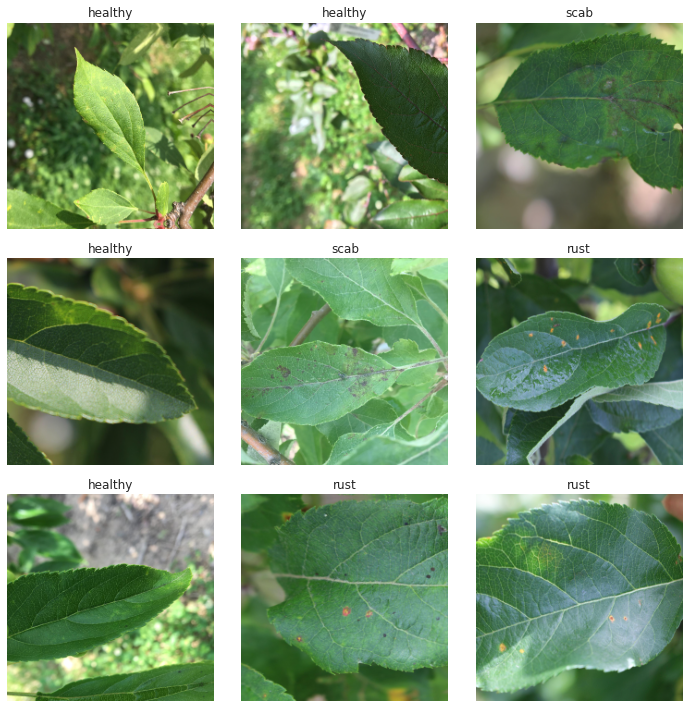

In [114]:
data.show_batch(rows=3, figsize=(10,10))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy])

In [38]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.264967,0.640932,0.807692,01:17
1,0.880950,0.538317,0.837912,01:18
2,0.670483,0.492597,0.848901,01:18
3,0.555880,0.487924,0.846154,01:18


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


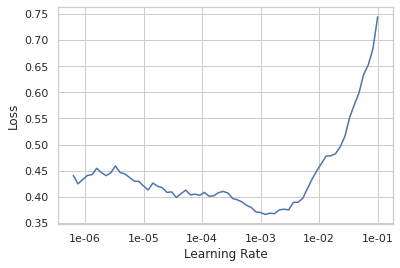

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(20, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.408659,0.486580,0.848901,01:17
1,0.372407,0.470885,0.854396,01:17
2,0.332474,0.441640,0.859890,01:18
3,0.318014,0.406489,0.868132,01:18
4,0.287814,0.378673,0.873626,01:18
5,0.252680,0.378050,0.884615,01:18
6,0.220299,0.391645,0.876374,01:18
7,0.183252,0.336386,0.890110,01:18
8,0.162298,0.325125,0.901099,01:18
9,0.140128,0.329996,0.901099,01:18


In [0]:
learn.save('stage-2')

# Pytorch Implementation

Loading the dataset

In [0]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy, argparse
import multiprocessing
from torchsummary import summary
from matplotlib import pyplot as plt

In [161]:
#split dataset into train and valid
df_copy = df.copy()
train_df = df.sample(frac=0.80, random_state=0)
valid_df = df.drop(train_df.index)
print('Original size:',(len(df)))
print('Train size:',len(train_df))
print('Valid valid:',len(valid_df))

Original size: 1821
Train size: 1457
Valid valid: 364


In [0]:
#allocate images to right folders
import shutil
from shutil import copyfile

train_scab = path/'train/scab/'
train_healthy = path/'train/healthy/'
train_rust = path/'train/rust/'
train_multiple = path/'train/multiple/'

valid_scab = path/'valid/scab/'
valid_healthy = path/'valid/healthy/'
valid_rust = path/'valid/rust/'
valid_multiple = path/'valid/multiple/'

for index, row in train_df.iterrows():
  image = row.image_id + '.jpg'
  scr = path/'images'/image
  if row.label == 'scab':
    shutil.copy(scr, train_scab)
  elif row.label == 'multiple_diseases':
    shutil.copy(scr, train_multiple)
  elif row.label == 'healthy':
    shutil.copy(scr, train_healthy)
  elif row.label == 'rust':
    shutil.copy(scr, train_rust)

for index, row in valid_df.iterrows():
  image = row.image_id + '.jpg'
  scr = path/'images'/image
  if row.label == 'scab':
    shutil.copy(scr, valid_scab)
  elif row.label == 'multiple_diseases':
    shutil.copy(scr, valid_multiple)
  elif row.label == 'healthy':
    shutil.copy(scr, valid_healthy)
  elif row.label == 'rust':
    shutil.copy(scr, valid_rust)

In [0]:
# Set the train and validation directory paths
train_directory = path/'train'
valid_directory = path/'valid'

In [0]:
# Batch size
bs = 64 
# Number of epochs
num_epochs = 10
# Number of classes
num_classes = 4
# Number of workers
num_cpu = multiprocessing.cpu_count()

In [0]:
# Applying transforms to the data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

In [0]:
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

In [0]:
# Create iterators for data loading
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                            num_workers=num_cpu), 
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True,
                            num_workers=num_cpu)
}

In [169]:
# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)

Classes: ['healthy', 'multiple', 'rust', 'scab']


In [170]:
# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

Training-set size: 1457 
Validation-set size: 364


In [0]:
# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [172]:
# Load a pretrained model - Resnet18
print("\nLoading resnet18...\n")
model_ft = models.resnet18(pretrained=True)

# Modify fc layers to match num_classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,num_classes)
model_ft = model_ft.to(device)


Loading resnet18...



In [173]:
# Print model summary
print('Model Summary:-\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(3, 224, 224))
print(model_ft)

Model Summary:-

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.1.conv1.weight True
10 layer1.1.bn1.weight True
11 layer1.1.bn1.bias True
12 layer1.1.conv2.weight True
13 layer1.1.bn2.weight True
14 layer1.1.bn2.bias True
15 layer2.0.conv1.weight True
16 layer2.0.bn1.weight True
17 layer2.0.bn1.bias True
18 layer2.0.conv2.weight True
19 layer2.0.bn2.weight True
20 layer2.0.bn2.bias True
21 layer2.0.downsample.0.weight True
22 layer2.0.downsample.1.weight True
23 layer2.0.downsample.1.bias True
24 layer2.1.conv1.weight True
25 layer2.1.bn1.weight True
26 layer2.1.bn1.bias True
27 layer2.1.conv2.weight True
28 layer2.1.bn2.weight True
29 layer2.1.bn2.bias True
30 layer3.0.conv1.weight True
31 layer3.0.bn1.weight True
32 layer3.0.bn1.bias True
33 layer3.0.conv2.weight True
34 layer3.0.bn2.weight True
35 layer3.0.b

In [0]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [0]:
# Optimizer 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [0]:
# Learning rate decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
# Model training routine 
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Tensorboard summary
    writer = SummaryWriter()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [178]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.1192 Acc: 0.5264
valid Loss: 0.7911 Acc: 0.7390

Epoch 1/9
----------
train Loss: 0.5588 Acc: 0.8545
valid Loss: 0.4448 Acc: 0.8599

Epoch 2/9
----------
train Loss: 0.3675 Acc: 0.8888
valid Loss: 0.3337 Acc: 0.8874

Epoch 3/9
----------
train Loss: 0.2820 Acc: 0.9115
valid Loss: 0.2840 Acc: 0.9066

Epoch 4/9
----------
train Loss: 0.2346 Acc: 0.9245
valid Loss: 0.2581 Acc: 0.9231

Epoch 5/9
----------
train Loss: 0.1964 Acc: 0.9355
valid Loss: 0.2328 Acc: 0.9313

Epoch 6/9
----------
train Loss: 0.1715 Acc: 0.9492
valid Loss: 0.2144 Acc: 0.9368

Epoch 7/9
----------
train Loss: 0.1533 Acc: 0.9492
valid Loss: 0.2115 Acc: 0.9396

Epoch 8/9
----------
train Loss: 0.1577 Acc: 0.9526
valid Loss: 0.2095 Acc: 0.9396

Epoch 9/9
----------
train Loss: 0.1519 Acc: 0.9554
valid Loss: 0.2085 Acc: 0.9396

Training complete in 8m 5s
Best val Acc: 0.939560


In [0]:
# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, path)

### Googlenet

In [0]:
# Load a pretrained model - Resnet18
print("\nLoading Googlenet...\n")
model_ft = models.googlenet(pretrained=True)

# Modify fc layers to match num_classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,num_classes)
model_ft = model_ft.to(device)


Loading Googlenet...



## To do:
1. I need to make predictions
2. Upload predictions to Kaggle
3. Improvements, iterations

### To improve
- Try different architecture models (Inception, Resnet50 etc)
- Try different data transforms
- Try different optimizer: Adam
- Train more epochs
